In [1]:
from hossam import load_data
from scipy.stats import t, ttest_1samp, normaltest, bartlett, levene, ttest_ind, ttest_rel, mannwhitneyu
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt
from pandas import melt, DataFrame
from statannotations.Annotator import Annotator
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [2]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

In [3]:
origin=load_data('sunlight_watering_growth')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/sunlight_watering_growth.xlsx
[desc] 식물의 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록한 데이터 (출처: 방송통신대학교 통계학개론)

field    description
-------  ----------------------------------------------------------------
water    각 식물에 물을 주는 빈도 (매일:`daily`, 매주: `weekly`)
sun      각 식물이 받은 햇빛 노출량 (낮음:`low`, 중간:`med`, 높음:`high`)
height   2개월 후 각 식물의 높이 (인치)


===== 데이터 크기 확인 =====
데이터셋 크기 : (120, 3)
행 개수 : 120개
열 개수 : 3개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   water   120 non-null    object 
 1   sun     120 non-null    object 
 2   height  120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None


,water,sun,height
0,daily,low,4.9
1,daily,low,7.9
2,daily,low,3.9
3,daily,low,5.1
4,daily,low,5.2


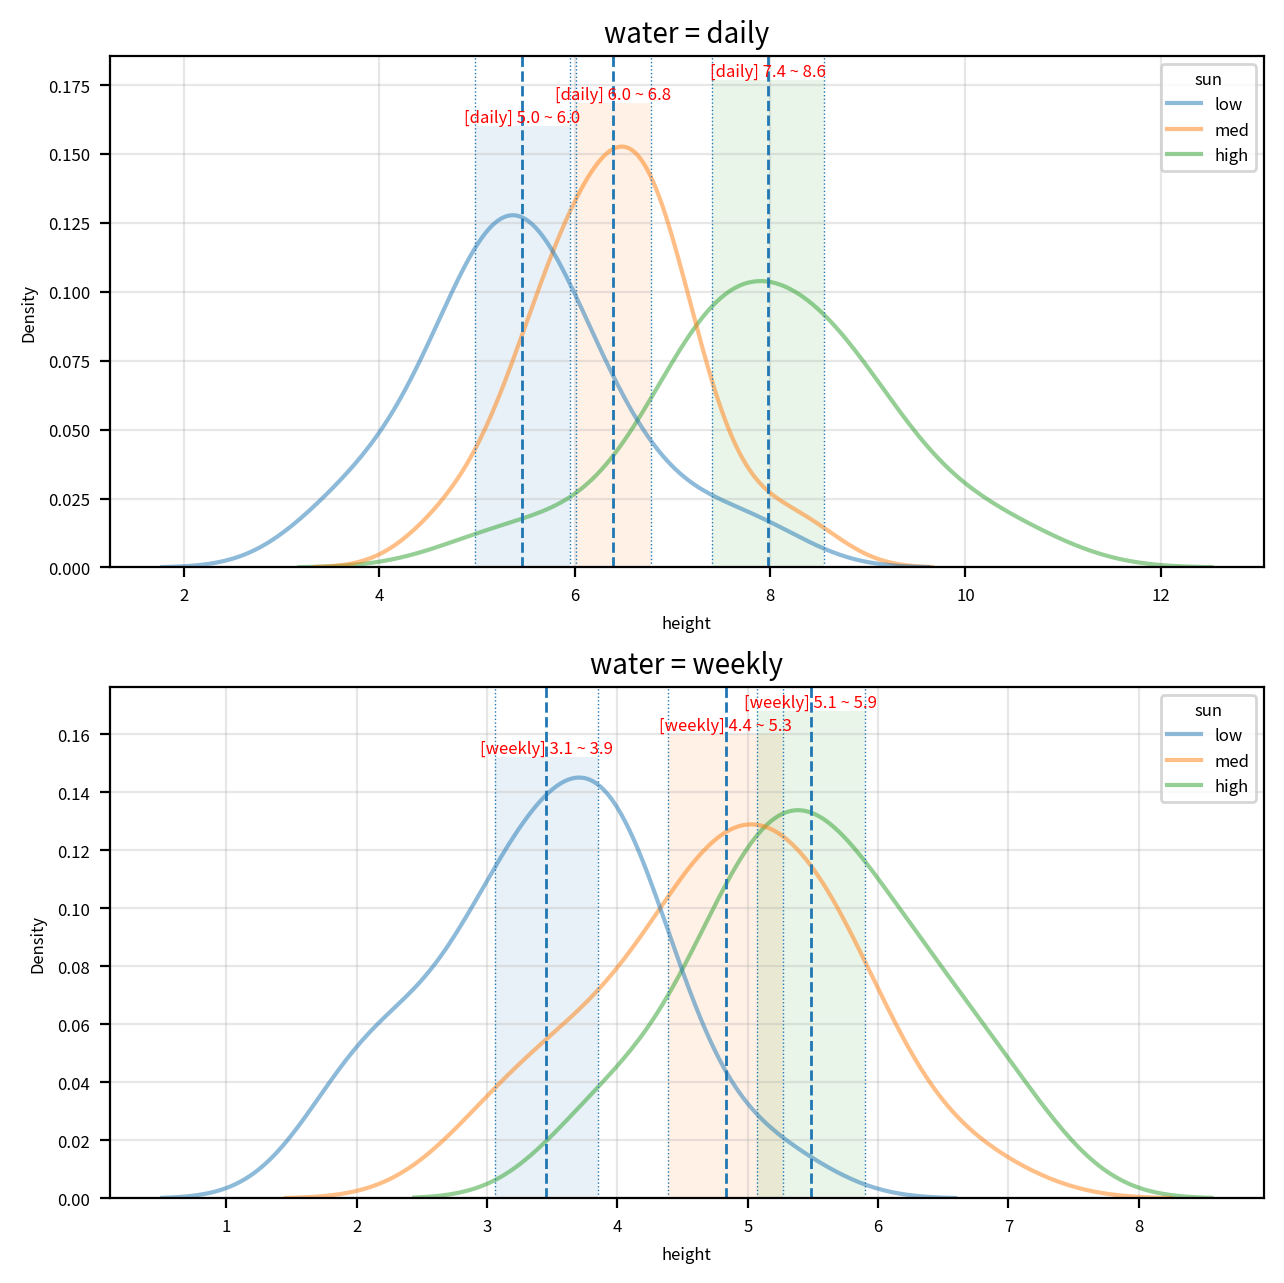

== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==


,statistic,p-value,result
field,,,
"daily, low",1.461514,0.481544,True
"daily, med",0.866582,0.648372,True
"daily, high",0.801917,0.669678,True
"weekly, low",0.073958,0.963697,True
"weekly, med",0.160764,0.922764,True
"weekly, high",0.052520,0.974082,True
Bartlett,4.488400,0.481437,True


,Source,SS,DF,MS,F,p-unc,np2
0,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
1,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
2,water * sun,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


-> water 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> sun 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> water * sun 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)
-> Residual 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)

[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun]
- 주효과 유의함 (p=2.01e-17) -> 사후검정 수행

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,6.7325,4.4600,2.2725,0.316503,7.180027,2.079377e-10,1.480100
1,high,med,6.7325,5.6125,1.1200,0.316503,3.538671,1.663237e-03,0.775153
2,low,med,4.4600,5.6125,-1.1525,0.316503,-3.641356,1.172021e-03,-0.888359



[water * sun] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.105) -> 단순주효과 분석 필요 없음


In [6]:
# 확인할 데이터
field='height'
group_field='water'
hue_field='sun'
df=origin[[field, group_field, hue_field]]
group_values=df[group_field].unique()
group_count=len(group_values)
hue_values=df[hue_field].unique()

# 그래프 초기화
rows=group_count
cols=1
width_px=1280*cols
height_px=640*rows
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 그래프 그리기
for i, v in enumerate(group_values):
    temp=df[df[group_field]==v]
    
    sb.kdeplot(data=temp, x=field, hue=hue_field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub=temp[temp[hue_field]==h]

        max=temp_sub[field].max()
        clevel=0.95
        dof=len(temp_sub[field])-1
        sp_mean=temp_sub[field].mean()
        sp_std=temp_sub[field].std(ddof=1)
        sp_std_error=sp_std/sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax=ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s='[%s] %0.1f ~ %0.1f'%(v, cmin, cmax),
                horizontalalignment='center',
                verticalalignment='bottom',
                fontdict={'size':6, 'color':'red'})

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

# 분산 분석의 가정 확인
groups=[(name, grp[field]) for name, grp in df.groupby(hue_field)]

equal_var_fields=[]
normal_dist=True
report=[]

for i in group_values:
    for j in hue_values:
        filtered_data=df[(df[group_field]==i)&(df[hue_field]==j)][field]
        equal_var_fields.append(filtered_data)

        s, p=normaltest(filtered_data)
        normalize=(p>0.05)
        report.append({
            'field':'{0}, {1}'.format(i,j),
            'statistic':s,
            'p-value':p,
            'result':normalize
        })
        normal_dist=normal_dist and normalize

if normal_dist:
    n='Bartlett'
    s, p=bartlett(*equal_var_fields)
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==')
    else:
        print('== 이 데이터는 정규성은 만족하지만, 등분산성을 만족하지 못한다 ==')
else:
    n='Levene'
    s, p=levene(*equal_var_fields, center='median')
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성은 만족하지 못하지만, 등분산성은 만족한다. ==')
    else:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족하지 못한다. ==')

equal_var=p>0.05
report.append({
    'field':n,
    'statistic':s,
    'p-value':p,
    'result':equal_var
})

report_df=DataFrame(report).set_index('field')
display(report_df)

# 이원 분산 분석
if equal_var:
    pg_anova=anova(data=df, dv=field, between=[group_field, hue_field])
else:
    pg_anova=welch_anova(data=df, dv=field, between=[group_field, hue_field])
display(pg_anova)

for idx in pg_anova.index:
    row=pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val<=0.05:
        print(f'-> {source} 효과는 유의함. (대립가설 채택 : p <= 0.05)')
    else:
        print(f'-> {source} 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)')

# 사후 검정
xname=[group_field, hue_field]
levels={}

for factor in xname:
    level_count=df[factor].nunique()
    levels[factor]=level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name=row['Source']
    p_value=row['p-unc']
    pvals[source_name]=p_value
for factor in xname:
    print(f'\n[{factor}]')
    if levels[factor]<=2:
        print(f'- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.')
        continue
    p_val=pvals.get(factor, None)
    if p_val is None:
        print('- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.')
        continue
    if p_val > 0.05:
        print(f'- 주효과 유의하지 않음 (p={p_val:.3g}) -> 사후검정 수행 안함')
        continue
    print(f'- 주효과 유의함 (p={p_val:.3g}) -> 사후검정 수행')

    if equal_var:
        print('\n=== Tukey HSD ===')
        hoc_df=pairwise_tukey(data=df, dv=field, between=factor)
    else:
        print('\n=== Games-Howell ===')
        hoc_df=pairwise_gameshowell(data=df, dv=field, between=factor)
    display(hoc_df)

# 상호작용 자동 처리
interaction_names=[src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val=pvals[inter]
    print(f'\n[{inter}] 상호작용 효과')

    if p_val<=0.05:
        print(f'- 상호작용 유의함 (p={p_val:.3g}) -> 단순주효과 분석 필요')
    else:
        print(f'- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음')

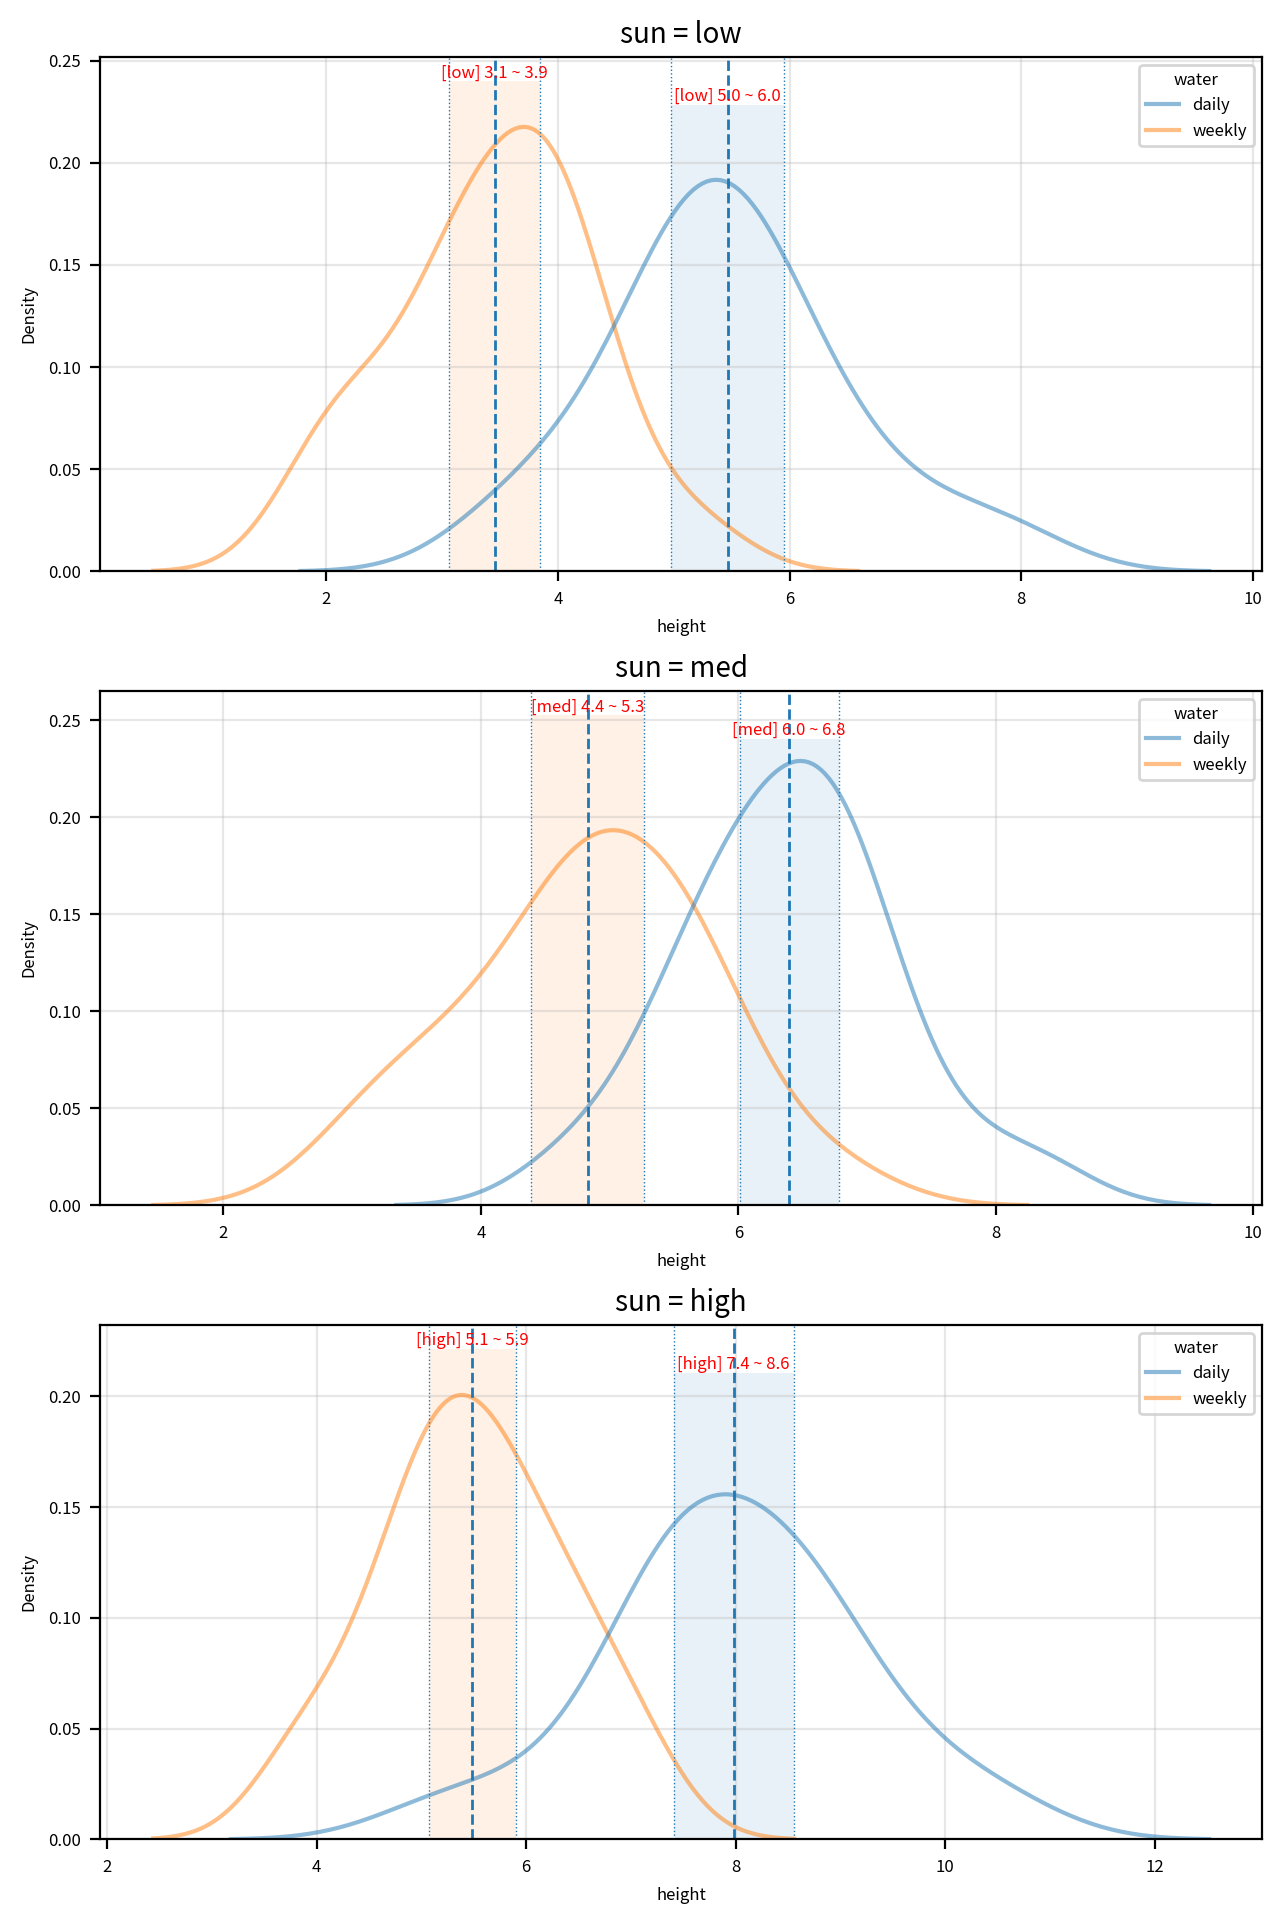

== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==


,statistic,p-value,result
field,,,
"low, daily",1.461514,0.481544,True
"low, weekly",0.073958,0.963697,True
"med, daily",0.866582,0.648372,True
"med, weekly",0.160764,0.922764,True
"high, daily",0.801917,0.669678,True
"high, weekly",0.052520,0.974082,True
Bartlett,4.488400,0.481437,True


,Source,SS,DF,MS,F,p-unc,np2
0,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
1,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
2,sun * water,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


-> sun 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> water 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> sun * water 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)
-> Residual 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)

[sun]
- 주효과 유의함 (p=2.01e-17) -> 사후검정 수행
=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,6.7325,4.4600,2.2725,0.316503,7.180027,2.079377e-10,1.480100
1,high,med,6.7325,5.6125,1.1200,0.316503,3.538671,1.663237e-03,0.775153
2,low,med,4.4600,5.6125,-1.1525,0.316503,-3.641356,1.172021e-03,-0.888359



[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun * water] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.105) -> 단순주효과 분석 필요 없음


In [7]:
# 확인할 데이터
field='height'
group_field='sun'
hue_field='water'
df=origin[[field, group_field, hue_field]]
group_values=df[group_field].unique()
group_count=len(group_values)
hue_values=df[hue_field].unique()

# 그래프 초기화
rows=group_count
cols=1
width_px=1280*cols
height_px=640*rows
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 그래프 그리기
for i, v in enumerate(group_values):
    temp=df[df[group_field]==v]
    
    sb.kdeplot(data=temp, x=field, hue=hue_field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub=temp[temp[hue_field]==h]

        max=temp_sub[field].max()
        clevel=0.95
        dof=len(temp_sub[field])-1
        sp_mean=temp_sub[field].mean()
        sp_std=temp_sub[field].std(ddof=1)
        sp_std_error=sp_std/sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax=ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s='[%s] %0.1f ~ %0.1f'%(v, cmin, cmax),
                horizontalalignment='center',
                verticalalignment='bottom',
                fontdict={'size':6, 'color':'red'})

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

# 분산 분석의 가정 확인
groups=[(name, grp[field]) for name, grp in df.groupby(hue_field)]

equal_var_fields=[]
normal_dist=True
report=[]

for i in group_values:
    for j in hue_values:
        filtered_data=df[(df[group_field]==i)&(df[hue_field]==j)][field]
        equal_var_fields.append(filtered_data)

        s, p=normaltest(filtered_data)
        normalize=(p>0.05)
        report.append({
            'field':'{0}, {1}'.format(i,j),
            'statistic':s,
            'p-value':p,
            'result':normalize
        })
        normal_dist=normal_dist and normalize

if normal_dist:
    n='Bartlett'
    s, p=bartlett(*equal_var_fields)
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==')
    else:
        print('== 이 데이터는 정규성은 만족하지만, 등분산성을 만족하지 못한다 ==')
else:
    n='Levene'
    s, p=levene(*equal_var_fields, center='median')
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성은 만족하지 못하지만, 등분산성은 만족한다. ==')
    else:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족하지 못한다. ==')

equal_var=p>0.05
report.append({
    'field':n,
    'statistic':s,
    'p-value':p,
    'result':equal_var
})

report_df=DataFrame(report).set_index('field')
display(report_df)

# 이원 분산 분석
if equal_var:
    pg_anova=anova(data=df, dv=field, between=[group_field, hue_field])
else:
    pg_anova=welch_anova(data=df, dv=field, between=[group_field, hue_field])
display(pg_anova)

for idx in pg_anova.index:
    row=pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val<=0.05:
        print(f'-> {source} 효과는 유의함. (대립가설 채택 : p <= 0.05)')
    else:
        print(f'-> {source} 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)')

# 사후 검정
xname=[group_field, hue_field]
levels={}

for factor in xname:
    level_count=df[factor].nunique()
    levels[factor]=level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name=row['Source']
    p_value=row['p-unc']
    pvals[source_name]=p_value
for factor in xname:
    print(f'\n[{factor}]')
    if levels[factor]<=2:
        print(f'- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.')
        continue
    p_val=pvals.get(factor, None)
    if p_val is None:
        print('- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.')
        continue
    if p_val > 0.05:
        print(f'- 주효과 유의하지 않음 (p={p_val:.3g}) -> 사후검정 수행 안함')
        continue
    print(f'- 주효과 유의함 (p={p_val:.3g}) -> 사후검정 수행')

    if equal_var:
        print('=== Tukey HSD ===')
        hoc_df=pairwise_tukey(data=df, dv=field, between=factor)
    else:
        print('=== Games-Howell ===')
        hoc_df=pairwise_gameshowell(data=df, dv=field, between=factor)
    display(hoc_df)

# 상호작용 자동 처리
interaction_names=[src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val=pvals[inter]
    print(f'\n[{inter}] 상호작용 효과')

    if p_val<=0.05:
        print(f'- 상호작용 유의함 (p={p_val:.3g}) -> 단순주효과 분석 필요')
    else:
        print(f'- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음')

In [1]:
from hossam import load_data
from scipy.stats import t, ttest_1samp, normaltest, bartlett, levene, ttest_ind, ttest_rel, mannwhitneyu
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt
from pandas import melt, DataFrame
from statannotations.Annotator import Annotator
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [2]:
origin=load_data('head_size')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/head_size.xlsx
[desc] 3명의 태아를 대상으로 3명의 관측자가 측정한 태아의 머리 둘레 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (60, 4)
행 개수 : 60개
열 개수 : 4개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정자번호   60 non-null     int64  
 1   1번태아    60 non-null     float64
 2   2번태아    60 non-null     float64
 3   3번태아    60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


In [4]:
origin=melt(origin, id_vars='측정자번호', value_vars=['1번태아', '2번태아', '3번태아'], var_name='태아번호', value_name='머리둘레')
origin.head()

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4


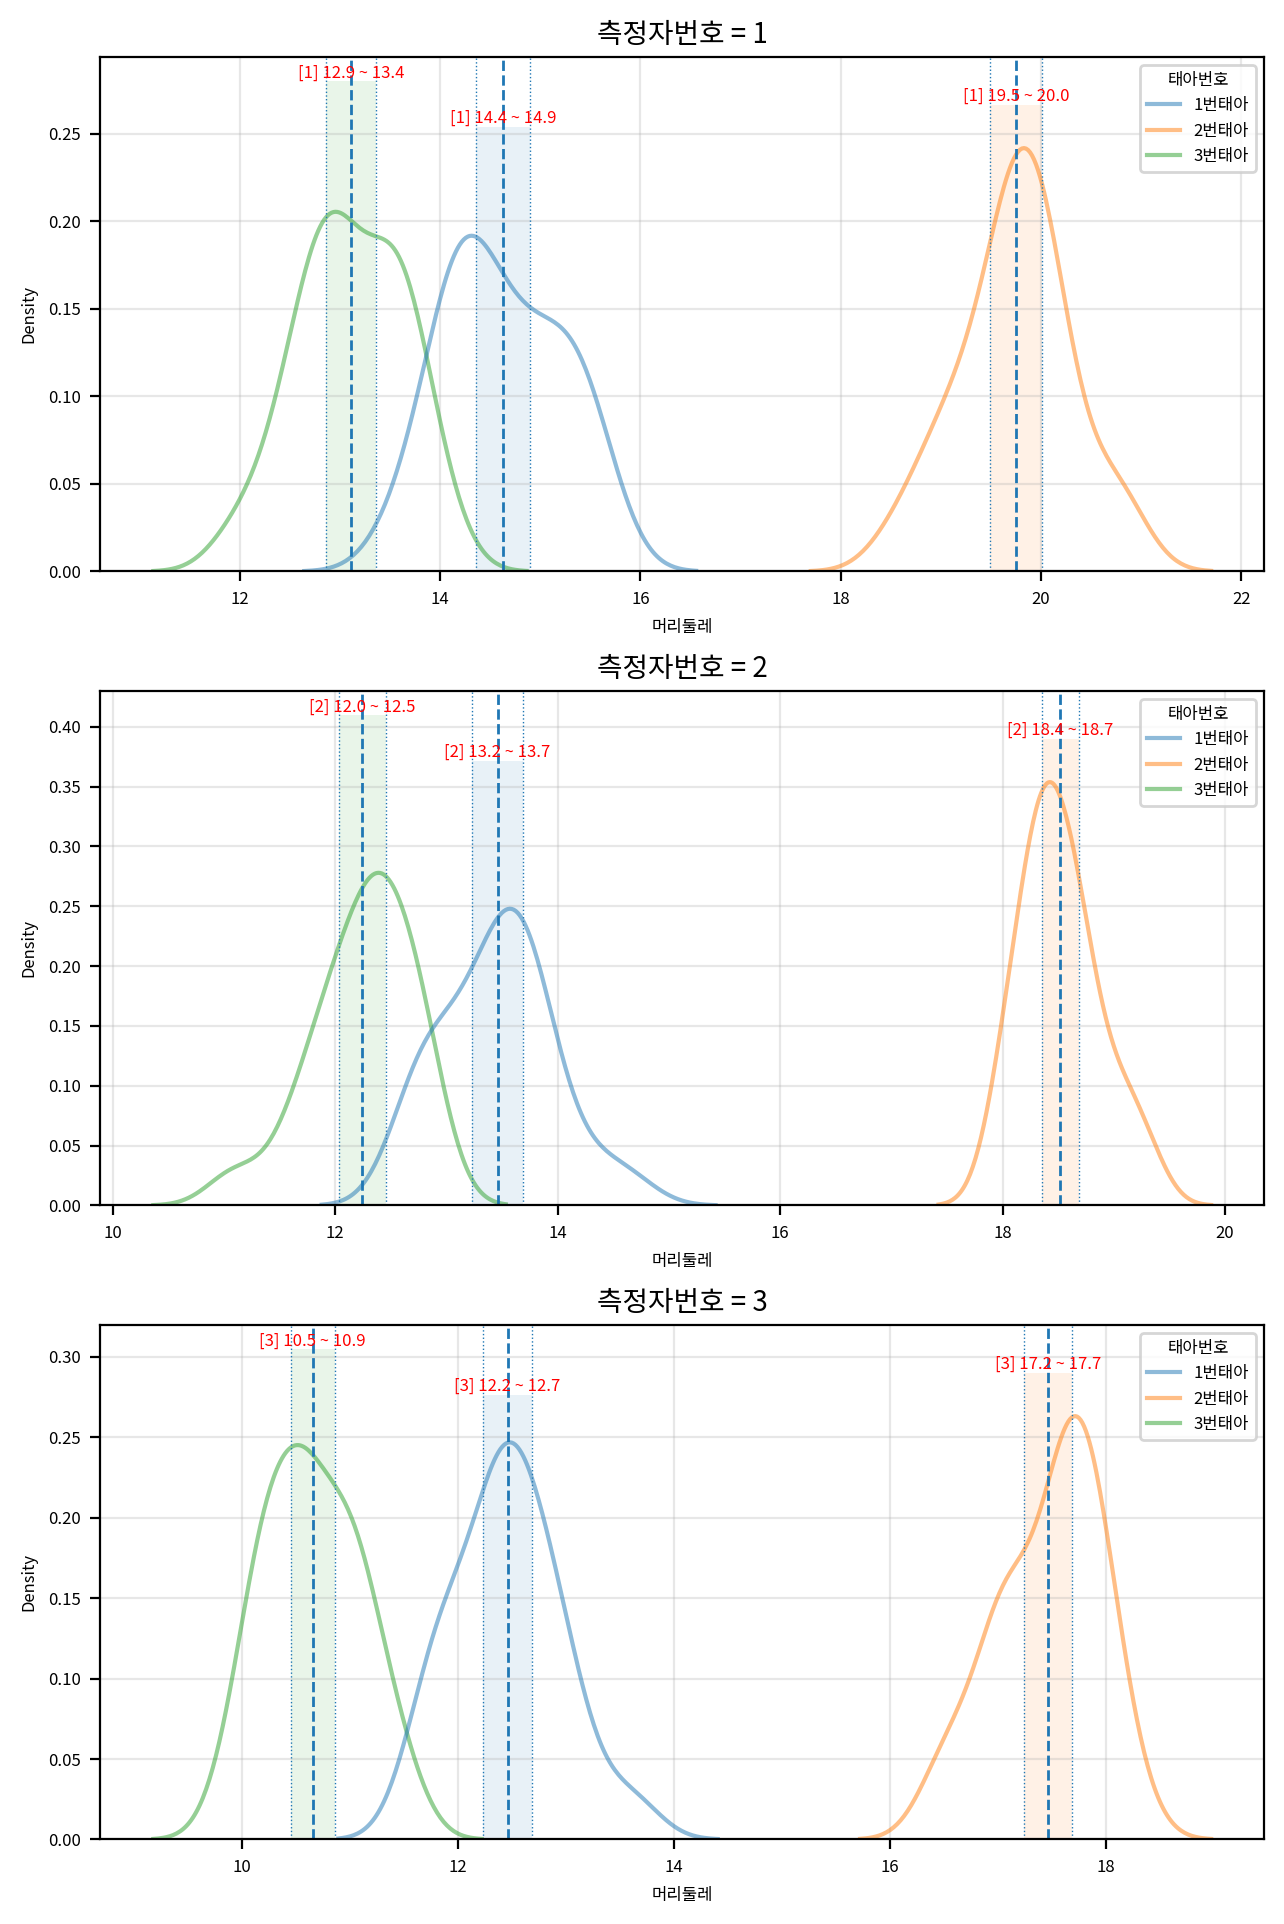

== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==


,statistic,p-value,result
field,,,
"1, 1번태아",1.885153,0.389623,True
"1, 2번태아",0.290183,0.864943,True
"1, 3번태아",0.408716,0.815171,True
"2, 1번태아",0.454973,0.796533,True
"2, 2번태아",1.442948,0.486035,True
"2, 3번태아",3.862339,0.144979,True
"3, 1번태아",0.666927,0.716438,True
"3, 2번태아",1.463170,0.481146,True
"3, 3번태아",0.846989,0.654755,True


,Source,SS,DF,MS,F,p-unc,np2
0,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
1,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
2,측정자번호 * 태아번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


-> 측정자번호 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> 태아번호 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> 측정자번호 * 태아번호 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)
-> Residual 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)

[측정자번호]
- 주효과 유의함 (p=4.9e-60) -> 사후검정 수행

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,15.830000,14.741667,1.088333,0.525341,2.071671,0.098702,0.380087
1,1,3,15.830000,13.526667,2.303333,0.525341,4.384456,0.000059,0.781644
2,2,3,14.741667,13.526667,1.215000,0.525341,2.312785,0.056613,0.422358



[태아번호]
- 주효과 유의함 (p=5.62e-134) -> 사후검정 수행

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1번태아,2번태아,13.516667,18.578333,-5.061667,0.195025,-25.953939,0.000000e+00,-4.841750
1,1번태아,3번태아,13.516667,12.003333,1.513333,0.195025,7.759689,1.915246e-12,1.393082
2,2번태아,3번태아,18.578333,12.003333,6.575000,0.195025,33.713629,0.000000e+00,6.016793



[측정자번호 * 태아번호] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.0583) -> 단순주효과 분석 필요 없음


In [6]:
# 확인할 데이터
field='머리둘레'
group_field='측정자번호'
hue_field='태아번호'

# 데이터 정리
df=origin[[field, group_field, hue_field]]
group_values=df[group_field].unique()
group_count=len(group_values)
hue_values=df[hue_field].unique()

# 그래프 초기화
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

rows=group_count
cols=1
width_px=1280*cols
height_px=640*rows
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 그래프 그리기
for i, v in enumerate(group_values):
    temp=df[df[group_field]==v]
    
    sb.kdeplot(data=temp, x=field, hue=hue_field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub=temp[temp[hue_field]==h]

        max=temp_sub[field].max()
        clevel=0.95
        dof=len(temp_sub[field])-1
        sp_mean=temp_sub[field].mean()
        sp_std=temp_sub[field].std(ddof=1)
        sp_std_error=sp_std/sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax=ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s='[%s] %0.1f ~ %0.1f'%(v, cmin, cmax),
                horizontalalignment='center',
                verticalalignment='bottom',
                fontdict={'size':6, 'color':'red'})

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

# 분산 분석의 가정 확인
groups=[(name, grp[field]) for name, grp in df.groupby(hue_field)]

equal_var_fields=[]
normal_dist=True
report=[]

for i in group_values:
    for j in hue_values:
        filtered_data=df[(df[group_field]==i)&(df[hue_field]==j)][field]
        equal_var_fields.append(filtered_data)

        s, p=normaltest(filtered_data)
        normalize=(p>0.05)
        report.append({
            'field':'{0}, {1}'.format(i,j),
            'statistic':s,
            'p-value':p,
            'result':normalize
        })
        normal_dist=normal_dist and normalize

if normal_dist:
    n='Bartlett'
    s, p=bartlett(*equal_var_fields)
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==')
    else:
        print('== 이 데이터는 정규성은 만족하지만, 등분산성을 만족하지 못한다 ==')
else:
    n='Levene'
    s, p=levene(*equal_var_fields, center='median')
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성은 만족하지 못하지만, 등분산성은 만족한다. ==')
    else:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족하지 못한다. ==')

equal_var=p>0.05
report.append({
    'field':n,
    'statistic':s,
    'p-value':p,
    'result':equal_var
})

report_df=DataFrame(report).set_index('field')
display(report_df)

# 이원 분산 분석
if equal_var:
    pg_anova=anova(data=df, dv=field, between=[group_field, hue_field])
else:
    pg_anova=welch_anova(data=df, dv=field, between=[group_field, hue_field])
display(pg_anova)

for idx in pg_anova.index:
    row=pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val<=0.05:
        print(f'-> {source} 효과는 유의함. (대립가설 채택 : p <= 0.05)')
    else:
        print(f'-> {source} 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)')

# 사후 검정
xname=[group_field, hue_field]
levels={}

for factor in xname:
    level_count=df[factor].nunique()
    levels[factor]=level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name=row['Source']
    p_value=row['p-unc']
    pvals[source_name]=p_value
for factor in xname:
    print(f'\n[{factor}]')
    if levels[factor]<=2:
        print(f'- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.')
        continue
    p_val=pvals.get(factor, None)
    if p_val is None:
        print('- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.')
        continue
    if p_val > 0.05:
        print(f'- 주효과 유의하지 않음 (p={p_val:.3g}) -> 사후검정 수행 안함')
        continue
    print(f'- 주효과 유의함 (p={p_val:.3g}) -> 사후검정 수행')

    if equal_var:
        print('\n=== Tukey HSD ===')
        hoc_df=pairwise_tukey(data=df, dv=field, between=factor)
    else:
        print('\n=== Games-Howell ===')
        hoc_df=pairwise_gameshowell(data=df, dv=field, between=factor)
    display(hoc_df)

# 상호작용 자동 처리
interaction_names=[src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val=pvals[inter]
    print(f'\n[{inter}] 상호작용 효과')

    if p_val<=0.05:
        print(f'- 상호작용 유의함 (p={p_val:.3g}) -> 단순주효과 분석 필요')
    else:
        print(f'- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음')

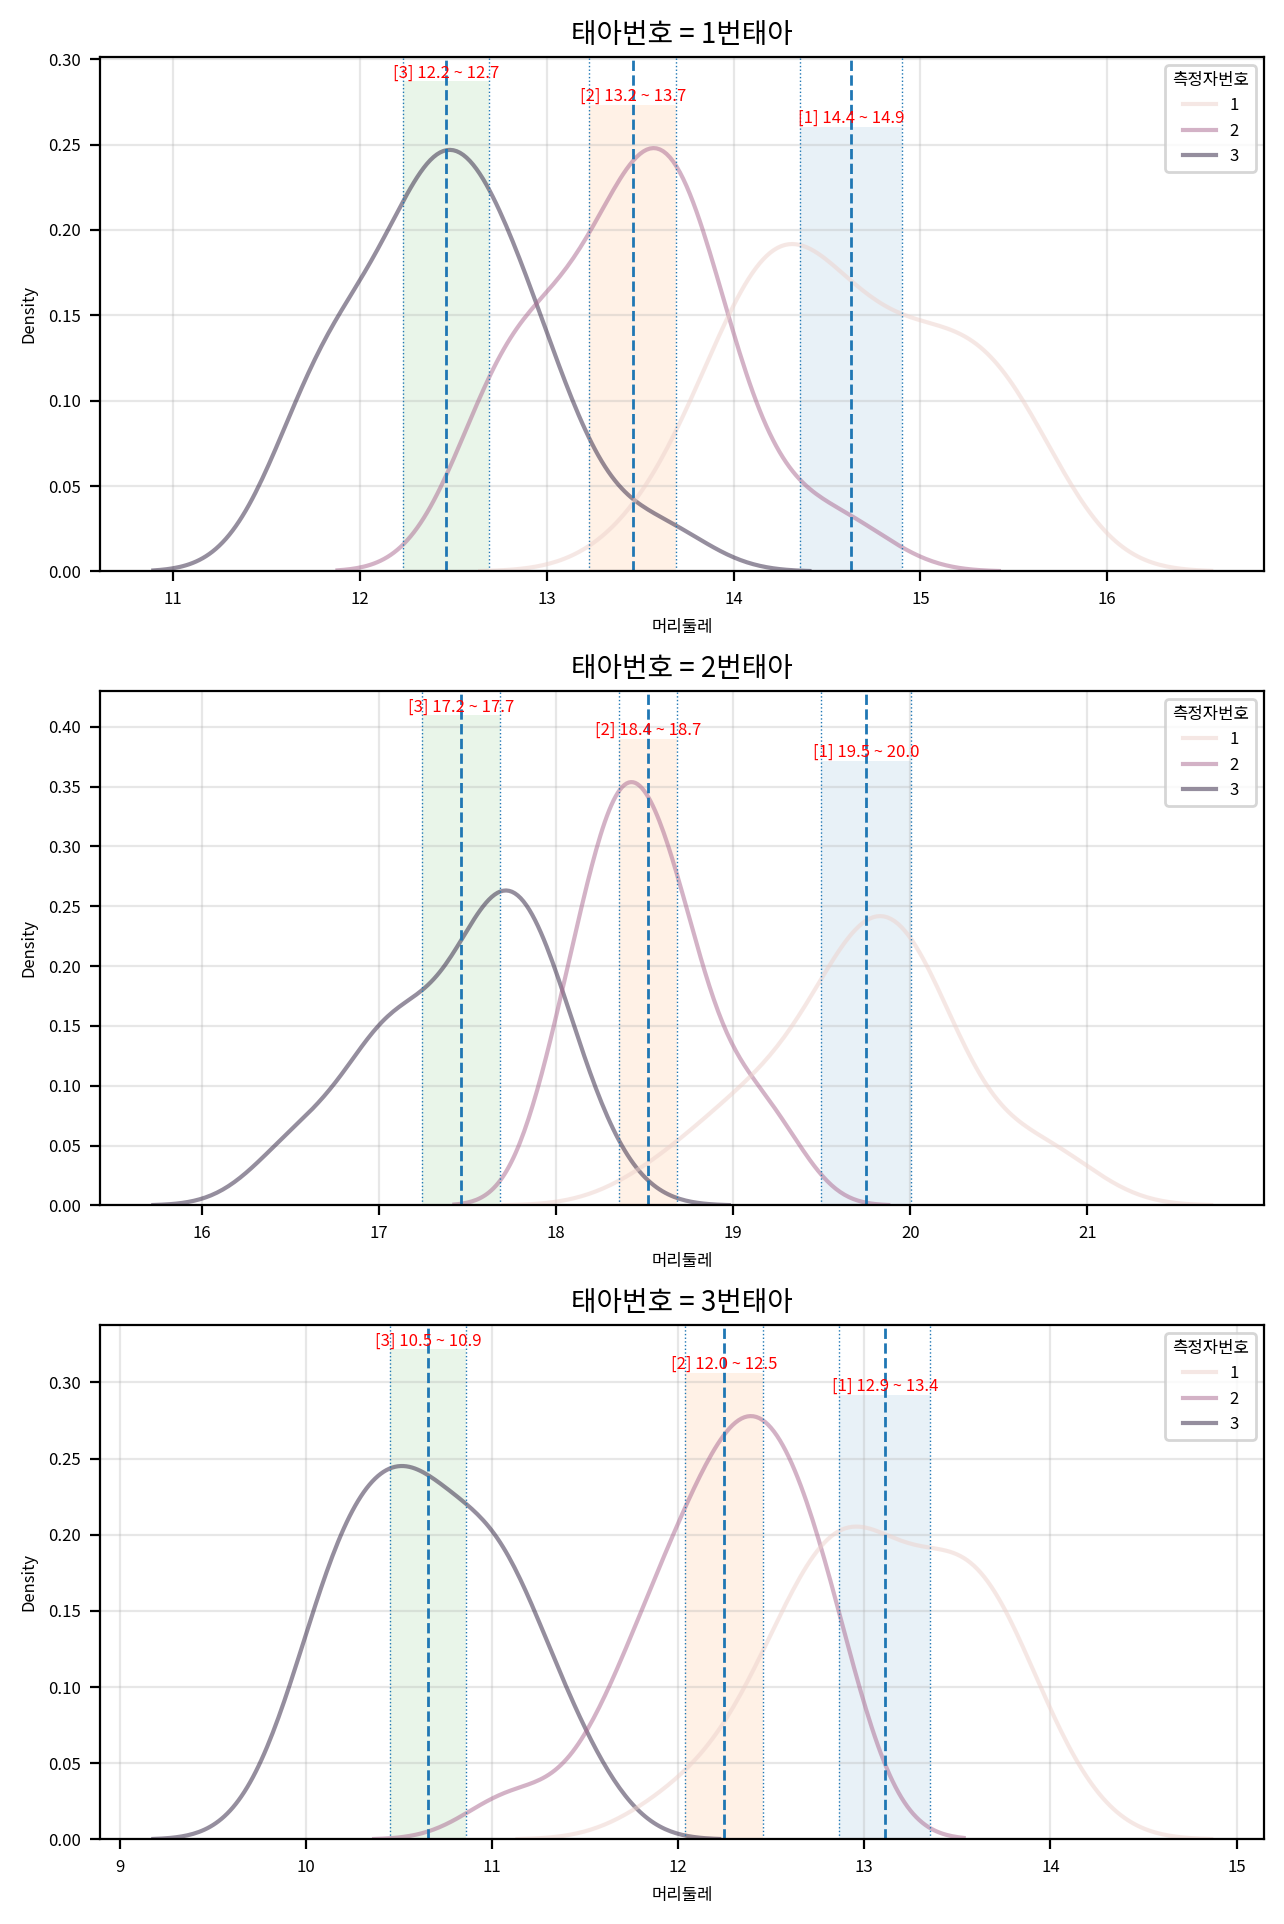

== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==


,statistic,p-value,result
field,,,
"1번태아, 1",1.885153,0.389623,True
"1번태아, 2",0.454973,0.796533,True
"1번태아, 3",0.666927,0.716438,True
"2번태아, 1",0.290183,0.864943,True
"2번태아, 2",1.442948,0.486035,True
"2번태아, 3",1.463170,0.481146,True
"3번태아, 1",0.408716,0.815171,True
"3번태아, 2",3.862339,0.144979,True
"3번태아, 3",0.846989,0.654755,True


,Source,SS,DF,MS,F,p-unc,np2
0,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
1,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
2,태아번호 * 측정자번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


-> 태아번호 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> 측정자번호 효과는 유의함. (대립가설 채택 : p <= 0.05)
-> 태아번호 * 측정자번호 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)
-> Residual 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)

[태아번호]
- 주효과 유의함 (p=5.62e-134) -> 사후검정 수행

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1번태아,2번태아,13.516667,18.578333,-5.061667,0.195025,-25.953939,0.000000e+00,-4.841750
1,1번태아,3번태아,13.516667,12.003333,1.513333,0.195025,7.759689,1.915246e-12,1.393082
2,2번태아,3번태아,18.578333,12.003333,6.575000,0.195025,33.713629,0.000000e+00,6.016793



[측정자번호]
- 주효과 유의함 (p=4.9e-60) -> 사후검정 수행

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,15.830000,14.741667,1.088333,0.525341,2.071671,0.098702,0.380087
1,1,3,15.830000,13.526667,2.303333,0.525341,4.384456,0.000059,0.781644
2,2,3,14.741667,13.526667,1.215000,0.525341,2.312785,0.056613,0.422358



[태아번호 * 측정자번호] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.0583) -> 단순주효과 분석 필요 없음


In [9]:
# 확인할 데이터
field='머리둘레'
group_field='태아번호'
hue_field='측정자번호'

# 데이터 정리
df=origin[[field, group_field, hue_field]]
group_values=df[group_field].unique()
group_count=len(group_values)
hue_values=df[hue_field].unique()

# 그래프 초기화
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

rows=group_count
cols=1
width_px=1280*cols
height_px=640*rows
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 그래프 그리기
for i, v in enumerate(group_values):
    temp=df[df[group_field]==v]
    
    sb.kdeplot(data=temp, x=field, hue=hue_field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub=temp[temp[hue_field]==h]

        max=temp_sub[field].max()
        clevel=0.95
        dof=len(temp_sub[field])-1
        sp_mean=temp_sub[field].mean()
        sp_std=temp_sub[field].std(ddof=1)
        sp_std_error=sp_std/sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax=ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s='[%s] %0.1f ~ %0.1f'%(h, cmin, cmax),
                horizontalalignment='center',
                verticalalignment='bottom',
                fontdict={'size':6, 'color':'red'})

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

# 분산 분석의 가정 확인
groups=[(name, grp[field]) for name, grp in df.groupby(hue_field)]

equal_var_fields=[]
normal_dist=True
report=[]

for i in group_values:
    for j in hue_values:
        filtered_data=df[(df[group_field]==i)&(df[hue_field]==j)][field]
        equal_var_fields.append(filtered_data)

        s, p=normaltest(filtered_data)
        normalize=(p>0.05)
        report.append({
            'field':'{0}, {1}'.format(i,j),
            'statistic':s,
            'p-value':p,
            'result':normalize
        })
        normal_dist=normal_dist and normalize

if normal_dist:
    n='Bartlett'
    s, p=bartlett(*equal_var_fields)
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==')
    else:
        print('== 이 데이터는 정규성은 만족하지만, 등분산성을 만족하지 못한다 ==')
else:
    n='Levene'
    s, p=levene(*equal_var_fields, center='median')
    homos=(p>0.05)
    if homos:
        print('== 이 데이터는 정규성은 만족하지 못하지만, 등분산성은 만족한다. ==')
    else:
        print('== 이 데이터는 정규성과 등분산성을 모두 만족하지 못한다. ==')

equal_var=p>0.05
report.append({
    'field':n,
    'statistic':s,
    'p-value':p,
    'result':equal_var
})

report_df=DataFrame(report).set_index('field')
display(report_df)

# 이원 분산 분석
if equal_var:
    pg_anova=anova(data=df, dv=field, between=[group_field, hue_field])
else:
    pg_anova=welch_anova(data=df, dv=field, between=[group_field, hue_field])
display(pg_anova)

for idx in pg_anova.index:
    row=pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val<=0.05:
        print(f'-> {source} 효과는 유의함. (대립가설 채택 : p <= 0.05)')
    else:
        print(f'-> {source} 효과는 유의하지 않음. (귀무가설 채택 : p > 0.05)')

# 사후 검정
xname=[group_field, hue_field]
levels={}

for factor in xname:
    level_count=df[factor].nunique()
    levels[factor]=level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name=row['Source']
    p_value=row['p-unc']
    pvals[source_name]=p_value
for factor in xname:
    print(f'\n[{factor}]')
    if levels[factor]<=2:
        print(f'- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.')
        continue
    p_val=pvals.get(factor, None)
    if p_val is None:
        print('- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.')
        continue
    if p_val > 0.05:
        print(f'- 주효과 유의하지 않음 (p={p_val:.3g}) -> 사후검정 수행 안함')
        continue
    print(f'- 주효과 유의함 (p={p_val:.3g}) -> 사후검정 수행')

    if equal_var:
        print('\n=== Tukey HSD ===')
        hoc_df=pairwise_tukey(data=df, dv=field, between=factor)
    else:
        print('\n=== Games-Howell ===')
        hoc_df=pairwise_gameshowell(data=df, dv=field, between=factor)
    display(hoc_df)

# 상호작용 자동 처리
interaction_names=[src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val=pvals[inter]
    print(f'\n[{inter}] 상호작용 효과')

    if p_val<=0.05:
        print(f'- 상호작용 유의함 (p={p_val:.3g}) -> 단순주효과 분석 필요')
    else:
        print(f'- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음')